In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import networkx as nx

nltk.download('gutenberg')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\groov\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
def get_alice_df():

    alice = nltk.corpus.gutenberg.raw('carroll-alice.txt')
    alice = alice.replace("\n\n", " ")
    alice = alice.replace("\n", " ")
    alice = alice.replace("[", "")
    alice = alice.replace("]", "")

    sent_text = nltk.sent_tokenize(alice)

    # build initial dataframe
    alice_df = pd.DataFrame(sent_text)
    alice_df.columns = ['sentence']

    # find the chapters, label them, and smash into a single dataframe
    chapters = alice_df[alice_df['sentence'].str.contains('CHAPTER')]

    chapter_dict = {}

    for i in range(1, len(chapters.index)):
        slice_min = chapters.index[i-1]
        slice_max = chapters.index[i]
        df = alice_df[slice_min:slice_max]
        df['chapter'] = i
        chapter_dict[str(i)] = df

    chapter_dict

    df = pd.concat(chapter_dict)
    df.reset_index(inplace=True, drop=True)
    df['sentence'] = df['sentence'] + ' ' # give it space between sentences for the groupby

    return df

In [5]:
alice_df = get_alice_df()
alice_df.head()

,sentence,chapter
0,Alice's Adventures in Wonderland by Lewis Carr...,1
1,Down the Rabbit-Hole Alice was beginning to ge...,1
2,So she was considering in her own mind (as wel...,1
3,There was nothing so VERY remarkable in that; ...,1
4,Oh dear!,1


In [4]:
chapter_df = alice_df.groupby('chapter').sum()
chapter_df

,sentence
chapter,
1,Alice's Adventures in Wonderland by Lewis Carr...
2,* * * * * * * * * ...
3,CHAPTER III. A Caucus-Race and a Long Tale The...
4,CHAPTER IV. The Rabbit Sends in a Little Bill ...
5,CHAPTER V. Advice from a Caterpillar The Cater...
6,CHAPTER VI. Pig and Pepper For a minute or two...
7,CHAPTER VII. A Mad Tea-Party There was a table...
8,CHAPTER VIII. The Queen's Croquet-Ground A lar...
9,CHAPTER IX. The Mock Turtle's Story 'You can't...


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize.casual import casual_tokenize

chapters = chapter_df['sentence']

# removing stopwords removes useful information, so don't do it unless you have to
tfidf = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3), lowercase=True)
tfidf_docs = tfidf.fit_transform(raw_documents=chapters)

tfidf_docs

<11x39152 sparse matrix of type '<class 'numpy.float64'>'
	with 54544 stored elements in Compressed Sparse Row format>

In [6]:
tfidf_df = pd.DataFrame(tfidf_docs.toarray(), columns=tfidf.get_feature_names(), index=chapter_df.index)
tfidf_df.head(3)

,!,"! ""","! "" ""","! "" '","! "" ?","! "" and","! "" but","! "" here","! "" i","! "" william",...,yourself to say,youth,"youth ,","youth , '",zealand,zealand or,zealand or australia,zigzag,"zigzag ,","zigzag , and"
chapter,,,,,,,,,,,,,,,,,,,,,
1,0.075098,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.007488,0.007488,0.007488,0.0,0.0,0.0
2,0.158806,0.003720,0.0,0.0,0.0,0.0,0.0,0.0,0.007389,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.106262,0.003829,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.007607,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [7]:
# you can use this to search for characters

col_df = pd.DataFrame(tfidf_df.columns)
col_df.columns = ['column']
col_df[col_df['column'].str.contains('judge')]

,column
1359,' the judge
8418,be judge
8419,"be judge ,"
17906,i'll be judge
19689,judge
19690,"judge ,"
19691,"judge , '"
19692,"judge , by"
19693,"judge , i'll"
19694,"judge , would"


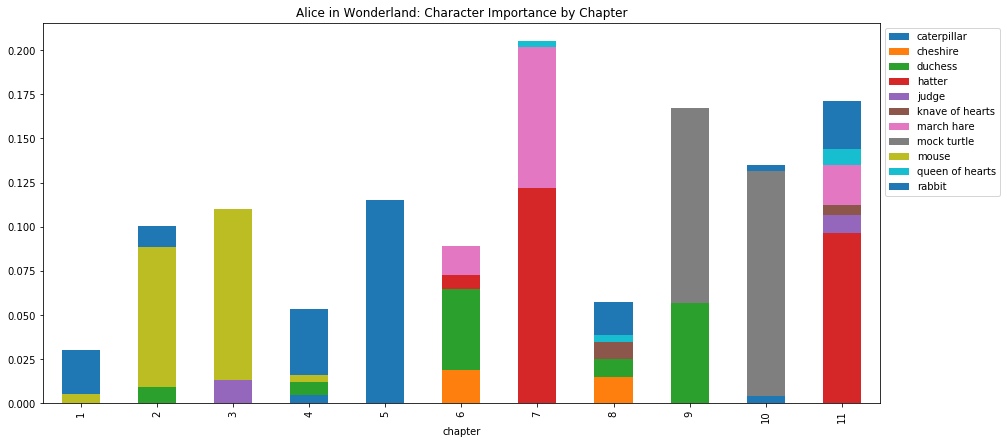

In [8]:
# just pick the interesting columns i want...

cols = ['rabbit', 'queen of hearts', 'knave of hearts', 'hatter', 'caterpillar', 'cheshire', 'duchess', 'mouse',
       'mock turtle', 'march hare', 'judge']
cols = sorted(cols)
tfidf_df[cols].plot.bar(figsize=(15,7), stacked=True, title='Alice in Wonderland: Character Importance by Chapter')
_= plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')


In [9]:
# # you can use this to read/skim through the book

# read_chapter = 1

# print(chapter_df.loc[read_chapter]['sentence'])

In [10]:
#graph_df.head()

In [11]:
from nltk import pos_tag_sents
from nltk.tokenize.casual import casual_tokenize

In [12]:
def create_entity_list(alice_df):

    graph_df = alice_df[alice_df['sentence'].str.contains('CHAPTER') == False]

    graph_df['tokens'] = graph_df['sentence'].apply(lambda x: casual_tokenize(x))
    pos_sents = pos_tag_sents(graph_df['tokens'])

    book_entities = []

    for sent in pos_sents:

        sent_entities = []

        for word_row in sent:
            word = word_row[0]
            pos_tag = word_row[1]

            if pos_tag == 'NNP':
                sent_entities.append(word)

        if len(sent_entities) > 1:
            book_entities.append(sent_entities)

    return book_entities

In [13]:
alice_df.head()

,sentence,chapter
0,Alice's Adventures in Wonderland by Lewis Carr...,1
1,Down the Rabbit-Hole Alice was beginning to ge...,1
2,So she was considering in her own mind (as wel...,1
3,There was nothing so VERY remarkable in that; ...,1
4,Oh dear!,1


In [14]:
entity_list = create_entity_list(alice_df)

In [15]:
G = nx.Graph()

for entity_row in entity_list:
    source = entity_row[0]
    targets = entity_row[1:]
    
    for target in targets:
        G.add_edge(source, target)

In [16]:
# add some edges edges
G.add_edge('Alice', 'Pool of Tears')
G.add_edge('Alice', 'Serpent')
G.add_edge('Canary', 'Lobster Quadrille')

In [17]:
drop_nodes = ['"', ');', '*', 'A', 'ALL', 'AND', 'ARE', 'AT', 'Ah', 'Anything', 'Arithmetic--Ambition', 'As', 'BEST', 
              'BOOTS', 'BUSY', 'Back', 'Beautiful', 'Behead', 'Boots', 'Bring', 'COULD', 'Can\'t', 'Consider', 'D',
             'DON\'T', 'DOTH', 'DRINK', 'Dear', 'Did', 'Distraction', 'Do', 'Does', 'Don\'t', 'Drink', 'Drive', 'EAT',
             'ESQ', 'EVERYBODY', 'English', 'Explain', 'FENDER', 'FOOT', 'Fainting', 'Fifteenth', 'First', 'Fourteenth',
             'Fury', 'Geography', 'Get', 'Go', 'Grammer', 'Grief', 'HE', 'HEARTHRUG', 'HEARTS', 'HERE', 'HIM', 'HOW',
             'Hadn\'t', 'Hand', 'He\'s', 'Hm', 'Hold', 'How', 'IF', 'IN', 'IT', 'ITS', 'Imagine', 'It\'ll', 'It\'s',
             'Jack-in-the-box', 'Keep', 'LESS', 'LITTLE', 'LOVE', 'Latin', 'Latitude', 'Let', 'Let\'s',
             'Longitude', 'Look', 'M', 'MARMALADE', 'ME', 'MINE', 'MUST', 'MYSELF', 'Ma\'am', 'Miss', 'Multiplication',
             'Mystery', 'NEAR', 'NEVER', 'NOT', 'Never', 'No', 'O', 'OF', 'OLD', 'ONE', 'ORANGE', 'OURS', 'OUT',
             'Oh', 'PLENTY', 'Pepper', 'Pig', 'Please', 'Poor', 'Pray', 'QUITE', 'RIGHT', 'Reeling', 'Repeat', 'SAID',
             'SHE', 'SHE\'S', 'Said', 'Same', 'Seaography', 'Seven', 'Shakespeare', 'She\'s', 'Shy', 'Silence', 'Sir',
             'Sit', 'Sixteenth', 'SLUGGARD', 'SHOES', 'SOMEBODY', 'SOUP', 'Soup', 'Speak', 'Stand', 'Stigand', 'Story',
             'Stretching', 'Suppose', 'Sure', 'THAT', 'THAT\'S', 'THE', 'THIS', 'TIS', 'Table', 'Take', 'Talking',
             'Tell', 'Thank', 'That\'s', 'There\'s', 'They\'re', 'Time', 'Tis', 'Too', 'Treacle', 'Turn', 'Twinkle',
             'Ugh', 'Uglification', 'VERY', 'VOICE', 'Very', 'WAISTCOAT-POCKET', 'WASHING--extra', 'WATCH', 'WHAT',
             'WITH', 'WOULD', 'Wake', 'Was', 'Well', 'What\'s', 'Which', 'Write', 'Writhing', 'YOU', 'YOUR',
             'You\'d', 'You\'ll', 'You\'re', 'You\'ve', 'Drawling', 'Drawling--the', 'Drawling-master', 'Curiouser',
             'Coils', 'Pennyworth', 'Edwin', 'Morcar', 'Mercia', 'Northumbria', 'England', 'France', 'FATHER',
             'William', 'WILLIAM', 'Derision', 'French', 'Canterbury', 'Conqueror', 'BEE', 'Ma', 'Nile', 'London',
             'Paris', 'Rome--no', 'Rome', 'New Zealand', 'Grammar', 'Australia', 'Father', 'Elsie', 'Lacie', 'Tillie',
             'Come', 'Australia', 'May', 'Hearts', 'New', 'Zealand', 'Puss']

G.remove_nodes_from(drop_nodes)

In [18]:
rename_nodes = {'ALICE\'S':'Alice', 'Mad':'Mad Hatter', 'MAD':'Mad Hatter', 'Hatter':'Mad Hatter', 'Hatter\'s':'Mad Hatter',
               'Alice\'s': 'Alice', 'Cat\'s':'Cheshire Cat', 'Caterpillar\'s':'Caterpillar', 'Cheshire':'Cheshire Cat',
               'Cat':'Cheshire Cat', 'Pool':'Pool of Tears', 'Tears':'Pool of Tears', 'Footman\'s':'Footman',
               'Footman':'Frog-Footman', 'I\'M':'Alice', 'I\'VE':'Alice', 'I\'d':'Alice', 'I\'ll':'Alice', 
                'I\'m':'Alice', 'I\'ve':'Alice', 'I--I':'Alice', 'I--I\'m':'Alice',
               'Dinah\'s':'Dinah', 'Dormouse\'s':'Dormouse', 'Duchess\'s':'Duchess', 'KING':'King of Hearts', 
                'King\'s':'King of Hearts',
               'Queen\'s':'Queen of Hearts', 'Will':'Alice', 'Mary':'Mary Ann', 'Ann':'Mary Ann', 'Mouse\'s':'Mouse',
               'Bill':'Lizard Bill', 'Lizard':'Lizard Bill', 'Hare':'March Hare', 'March':'March Hare',
               'Lobster':'Lobster Quadrille', 'Quadrille':'Lobster Quadrille', 'Mock':'Mock Turtle',
               'Turtle':'Mock Turtle', 'Turtle\'s':'Mock Turtle', 'White':'White Rabbit', 'Rabbit':'White Rabbit',
               'Rabbit\'s':'White Rabbit', 'QUEEN':'Queen of Hearts', 'Knave':'Knave of Hearts', 'King':'King of Hearts',
               'Queen':'Queen of Hearts'}

G = nx.relabel_nodes(G, rename_nodes)

In [19]:
sorted(G.nodes)

['Ada',
 'Alice',
 'Atheling',
 'Canary',
 'Caterpillar',
 'Caucus-race',
 'Cheshire Cat',
 'Christmas',
 'Croquet-Ground',
 'Dinah',
 'Dinn',
 'Dodo',
 'Dormouse',
 'Duchess',
 'Duck',
 'Eaglet',
 'Edgar',
 'Fish-Footman',
 'Footman',
 'Frog-Footman',
 'Gryphon',
 'King of Hearts',
 'Kings',
 'Knave of Hearts',
 'Lizard Bill',
 'Lobster Quadrille',
 'Lory',
 'Mabel',
 'Mad Hatter',
 'Majesty',
 'March Hare',
 'Mary Ann',
 'Mock Turtle',
 'Mouse',
 'Owl',
 'Panther',
 'Pigeon',
 'Pool of Tears',
 'Queen of Hearts',
 'Queens',
 'Serpent',
 'Tea-Party',
 'Tortoise',
 'White Rabbit']

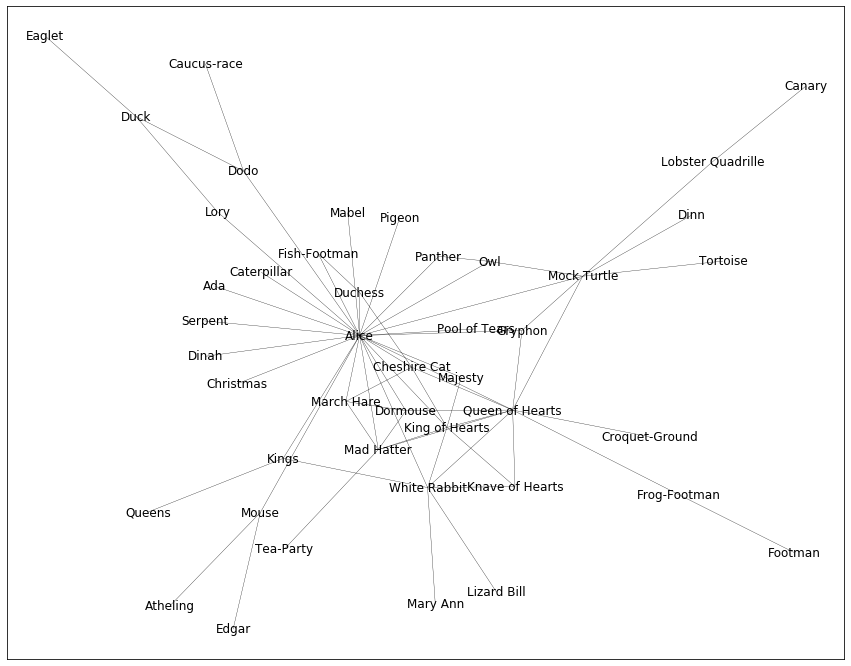

In [20]:
plt.subplots(figsize=(15,12))

nx.draw_networkx(G, node_size=0, width=0.3)

In [21]:
lookup = 'Hatter'

for sentence in alice_df[alice_df['sentence'].str.contains(lookup)]['sentence']:
    print(sentence)
    print()

'In THAT direction,' the Cat said, waving its right paw round, 'lives a Hatter: and in THAT direction,' waving the other paw, 'lives a March Hare. 

I almost wish I'd gone to see the Hatter instead!' 

A Mad Tea-Party There was a table set out under a tree in front of the house, and the March Hare and the Hatter were having tea at it: a Dormouse was sitting between them, fast asleep, and the other two were using it as a cushion, resting their elbows on it, and talking over its head. 

'Your hair wants cutting,' said the Hatter. 

The Hatter opened his eyes very wide on hearing this; but all he SAID was, 'Why is a raven like a writing-desk?' 

said the Hatter. 

'It IS the same thing with you,' said the Hatter, and here the conversation dropped, and the party sat silent for a minute, while Alice thought over all she could remember about ravens and writing-desks, which wasn't much. 

The Hatter was the first to break the silence. 

sighed the Hatter. 

'Yes, but some crumbs must have got

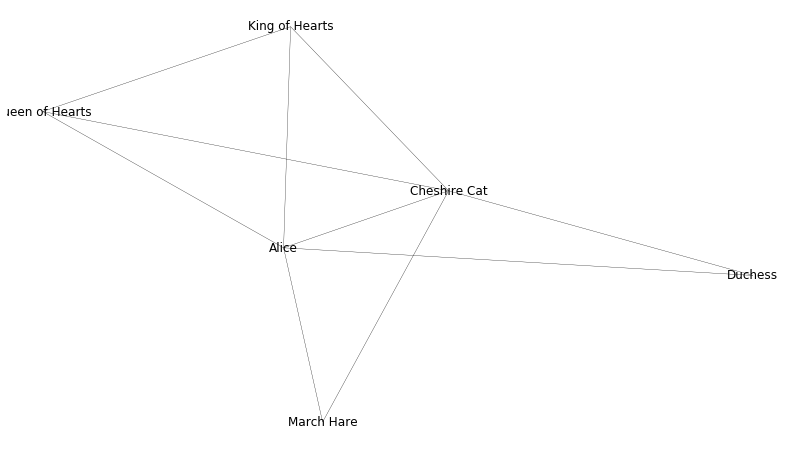

In [22]:
plt.subplots(figsize=(14,8))
ego = nx.ego_graph(G, 'Cheshire Cat')
nx.draw(ego, node_size=0, with_labels=True, width=0.3)

In [23]:
sorted(G.edges('Cheshire Cat'))

[('Cheshire Cat', 'Alice'),
 ('Cheshire Cat', 'Cheshire Cat'),
 ('Cheshire Cat', 'Duchess'),
 ('Cheshire Cat', 'King of Hearts'),
 ('Cheshire Cat', 'March Hare'),
 ('Cheshire Cat', 'Queen of Hearts')]

In [24]:
G.degree('Cheshire Cat')

7

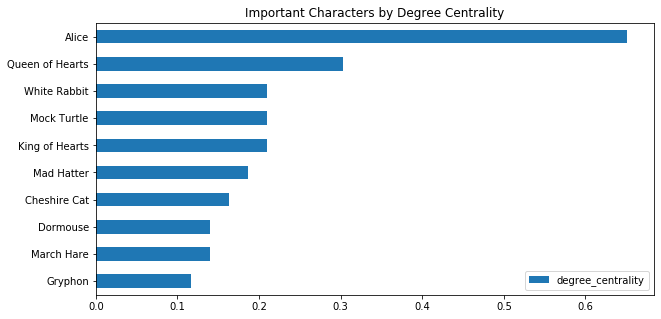

In [25]:
check_df = pd.DataFrame(nx.degree_centrality(G), index=[0]).T
check_df.columns = ['degree_centrality']
check_df.sort_values('degree_centrality', inplace=True, ascending=False)
check_df.head(10).plot.barh(title='Important Characters by Degree Centrality', figsize=(10, 5))
plt.gca().invert_yaxis()

In [27]:
import sknetwork as sk

from IPython.display import SVG

from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

from scipy import sparse


import numpy as np

In [78]:
adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr')
adjacency.toarray()

array([[1, 1, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int32)

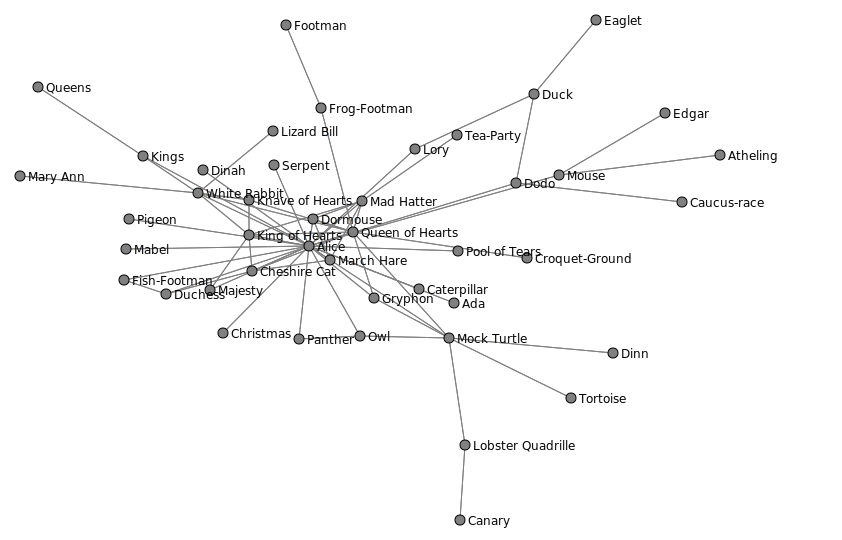

In [80]:
adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr')
names = np.array(list(G.nodes()))

image = svg_graph(adjacency, node_size=5, names=names,width=700, height=500)
SVG(image)

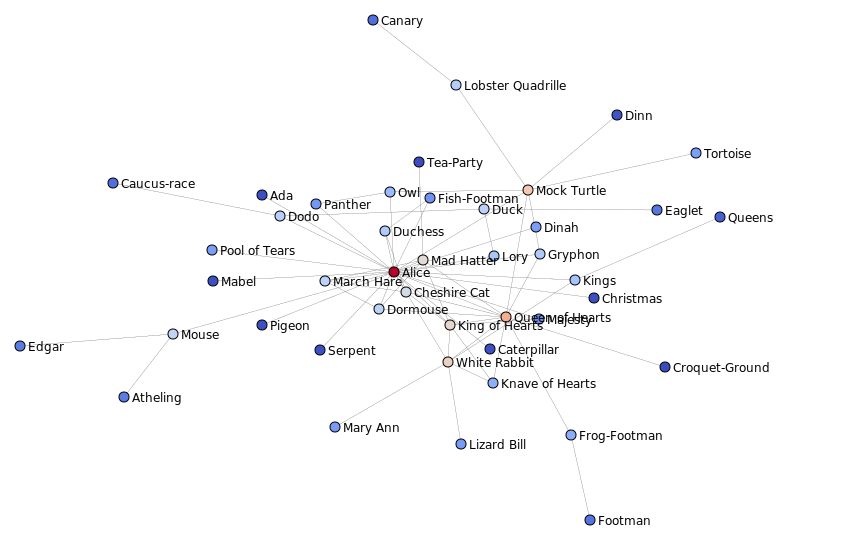

In [84]:
from sknetwork.data import Bunch, load, save
from sknetwork.ranking import PageRank, BiPageRank

graph = Bunch()
graph.adjacency = adjacency
graph.names = np.array(names)

pagerank = PageRank()
scores = pagerank.fit_transform(adjacency)
image = svg_graph(graph.adjacency, node_size=5, names=graph.names,width=700, height=500, scores=np.log(scores),
                 edge_width=0.2)
SVG(image)

In [83]:
save('mygraph', graph)